# **Import Library**

In [ ]:
!pip install opencv-python

In [ ]:
from glob import glob
import cv2 as cv
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import kagglehub
plt.rcParams["image.cmap"] = "gray"
import glob
import joblib
from scipy.cluster.vq import kmeans, vq
from numpy.linalg import norm

# **Upload data**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("dohahemdan202200701/sift-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sift-images


In [ ]:
# List all image files in the dataset directory
image = glob.glob(os.path.join(path, "**/*.jpg"), recursive=True)
image.extend(glob.glob(os.path.join(path, "**/*.png"), recursive=True))

# Print the number of images found
print(f"Found {len(image)} images")

Found 3600 images


In [ ]:
len(image),type(image)

(3600, list)

# **Load and read the image**

In [ ]:
data1=[]
for i in range(3600):
    data1.append(cv.imread(image[i],1))


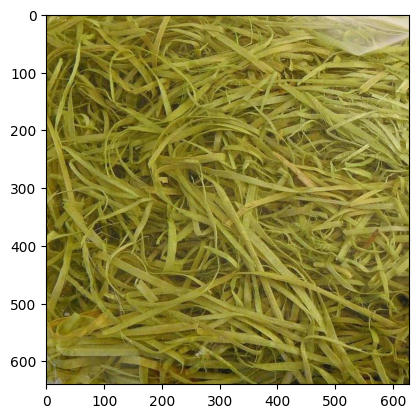

In [ ]:
plt.imshow(data1[0][:,:,::-1])

In [ ]:
images = []
for n in range(0, len(data1)):
    images.append(np.array(data1[n]))

In [ ]:
bw_images = []
for img in images:
    if len(img.shape) == 3:
        bw_images.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    else:
        bw_images.append(img)

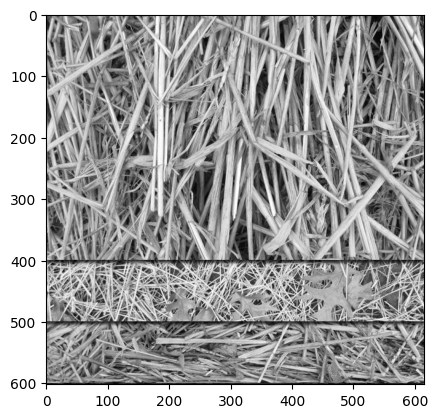

In [ ]:
plt.imshow(bw_images[1])
plt.show()

# **Extract Features by SIFT**

In [ ]:
# Initialize the SIFT feature extractor
extractor = cv.SIFT_create()

# Lists to store keypoints and descriptors for each image
keypoints = []
descriptors = []

# Loop through each black-and-white image to detect keypoints and compute descriptors
for img in bw_images:
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

In [ ]:
print(len(descriptors))

3600


In [ ]:
# Identify images with no descriptors
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    if img_descriptors is None:
        to_drop.append(i)

# Print the indices of images to be dropped
print(to_drop)

# Remove the images with no descriptors from both descriptors and keypoints lists
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(len(descriptors))

[546, 547, 565, 568, 653, 693, 708, 842, 879, 904, 911, 915, 950, 1472, 2160, 2166, 2180, 2191, 2194, 2210, 2213, 2218, 2219, 2227, 2239, 2261, 2277, 2547, 2595, 2644, 2655, 2660, 2694, 2758, 2759, 2908, 2987, 3184, 3198, 3360, 3361, 3364, 3368, 3369, 3371, 3375, 3378, 3383, 3384, 3394, 3396, 3403, 3405, 3409, 3426, 3434, 3436, 3438, 3441, 3442, 3445, 3450, 3453, 3459, 3464, 3467, 3471, 3472, 3476, 3478]
3530


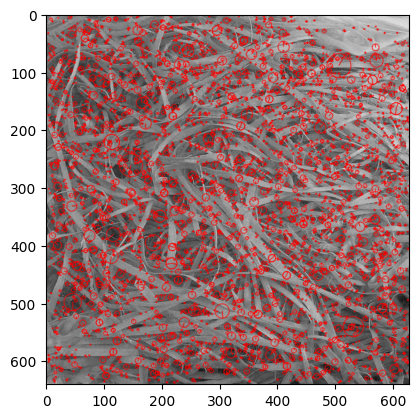

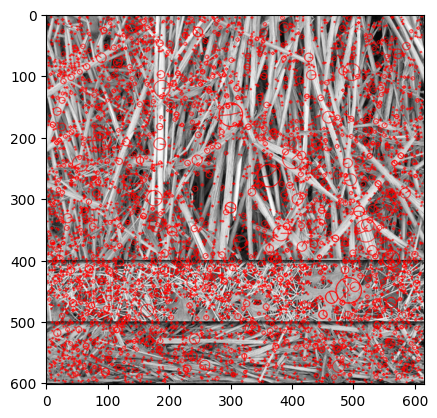

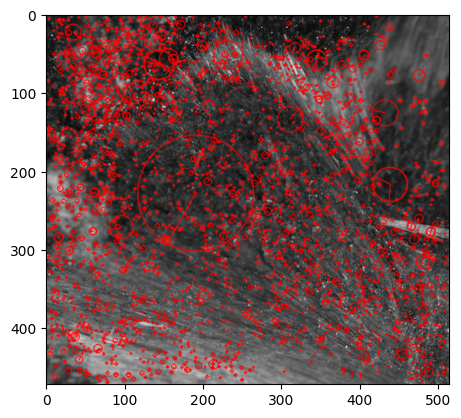

In [ ]:
# Visualize the keypoints on the first three images
output_image = []
for x in range(3):
    output_image.append(cv.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x])
    plt.show()

# **Experiment 1: Varying the number of images used to compute centroids**

In [ ]:
def experiment_vary_images(num_images_list):
    results = {}  # Dictionary to store results for each experiment

    # Loop through each number of images in the provided list
    for num_images in num_images_list:
        # Set random seed for reproducibility
        np.random.seed(0)

        # Randomly sample indices for the specified number of images
        sample_idx = np.random.randint(0, len(descriptors), num_images).tolist()

        # Extract descriptors for the sampled images
        descriptors_sample = [descriptors[i] for i in sample_idx]

        # Stack all descriptors into a single array for k-means clustering
        all_descriptors = np.vstack(descriptors_sample)

        # Define k-means parameters
        k = 250  # Number of clusters (visual words)
        iters = 4  # Number of iterations for k-means
        codebook, variance = kmeans(all_descriptors, k, iters)

        # Map descriptors of each image to the nearest visual word in the codebook
        visual_words = []
        for img_descriptors in descriptors_sample:
            words, _ = vq(img_descriptors, codebook)
            visual_words.append(words)

        # Compute frequency vectors (histograms of visual words) for each image
        frequency_vectors = []
        for img_visual_words in visual_words:
            img_frequency_vector = np.zeros(k)
            for word in img_visual_words:
                img_frequency_vector[word] += 1
            frequency_vectors.append(img_frequency_vector)
        frequency_vectors = np.stack(frequency_vectors)

        # Compute TF-IDF (Term Frequency-Inverse Document Frequency) weights
        N = len(frequency_vectors)
        df = np.sum(frequency_vectors > 0, axis=0)
        idf = np.log(N / df)
        tfidf = frequency_vectors * idf

        # Randomly select an image to use as the query
        search_i = np.random.randint(0, num_images)
        a = tfidf[search_i]
        b = tfidf

        # Compute cosine similarity between the query image and all other images
        cosine_similarity = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))

        # Store results for this experiment
        results[num_images] = {
            "min_cosine": round(np.min(cosine_similarity), 1),  # Minimum cosine similarity
            "max_cosine": np.max(cosine_similarity),  # Maximum cosine similarity
            "top_k_images": np.argsort(-cosine_similarity)[:2]  # Indices of top 2 most similar images
        }

        # Print experiment results
        print(f"Experiment with {num_images} images:")
        print("Minimum cosine similarity:", results[num_images]["min_cosine"])
        print("Maximum cosine similarity:", results[num_images]["max_cosine"])

        # Visualize the top 2 most similar images
        for i in results[num_images]["top_k_images"]:
            print(f"Image {i}: Cosine Similarity = {round(cosine_similarity[i], 4)}")
            plt.imshow(bw_images[i], cmap='gray')
            plt.title(f"Image {i} (Cosine Similarity = {round(cosine_similarity[i], 4)})")
            plt.show()

    return results

# **Experiment 2: Varying the number of centroids**

In [ ]:
def experiment_vary_centroids(num_centroids_list):
    results = {}
    np.random.seed(0)

    # Randomly sample 500 images for the experiment
    sample_idx = np.random.randint(0, len(descriptors), 500).tolist()
    descriptors_sample = [descriptors[i] for i in sample_idx]
    all_descriptors = np.vstack(descriptors_sample)

    for k in num_centroids_list:
        iters = 4
        codebook, variance = kmeans(all_descriptors, k, iters)

        visual_words = []
        for img_descriptors in descriptors_sample:
            words, _ = vq(img_descriptors, codebook)
            visual_words.append(words)

        frequency_vectors = []
        for img_visual_words in visual_words:
            img_frequency_vector = np.zeros(k)
            for word in img_visual_words:
                img_frequency_vector[word] += 1
            frequency_vectors.append(img_frequency_vector)
        frequency_vectors = np.stack(frequency_vectors)

        N = len(frequency_vectors)
        df = np.sum(frequency_vectors > 0, axis=0)
        idf = np.log(N / df)
        tfidf = frequency_vectors * idf

        search_i = np.random.randint(0, 500)
        a = tfidf[search_i]
        b = tfidf
        cosine_similarity = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))

        results[k] = {
            "min_cosine": round(np.min(cosine_similarity), 1),
            "max_cosine": np.max(cosine_similarity),
            "top_k_images": np.argsort(-cosine_similarity)[:2]
        }

        print(f"Experiment with {k} centroids:")
        print("Minimum cosine similarity:", results[k]["min_cosine"])
        print("Maximum cosine similarity:", results[k]["max_cosine"])

        for i in results[k]["top_k_images"]:
            print(f"Image {i}: Cosine Similarity = {round(cosine_similarity[i], 4)}")
            plt.imshow(bw_images[i], cmap='gray')
            plt.title(f"Image {i} (Cosine Similarity = {round(cosine_similarity[i], 4)})")
            plt.show()

    return results

# **Experiment 3: Comparing TF-IDF and Bag of Words (BoW)**

In [ ]:
def experiment_tfidf_vs_bow():
    np.random.seed(0)
    sample_idx = np.random.randint(0, len(descriptors), 500).tolist()
    descriptors_sample = [descriptors[i] for i in sample_idx]
    all_descriptors = np.vstack(descriptors_sample)

    k = 250
    iters = 4
    codebook, variance = kmeans(all_descriptors, k, iters)

    # TF-IDF
    visual_words = []
    for img_descriptors in descriptors_sample:
        words, _ = vq(img_descriptors, codebook)
        visual_words.append(words)

    frequency_vectors = []
    for img_visual_words in visual_words:
        img_frequency_vector = np.zeros(k)
        for word in img_visual_words:
            img_frequency_vector[word] += 1
        frequency_vectors.append(img_frequency_vector)
    frequency_vectors = np.stack(frequency_vectors)

    N = len(frequency_vectors)
    df = np.sum(frequency_vectors > 0, axis=0)
    idf = np.log(N / df)
    tfidf = frequency_vectors * idf

    search_i = np.random.randint(0, 500)
    a = tfidf[search_i]
    b = tfidf
    cosine_similarity_tfidf = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))

    # BoW
    frequency_vectors_bow = frequency_vectors  # BoW is just the frequency vectors without IDF
    cosine_similarity_bow = np.dot(a, frequency_vectors_bow.T) / (norm(a) * norm(frequency_vectors_bow, axis=1))

    print("TF-IDF vs BoW Experiment:")
    print("TF-IDF Minimum cosine similarity:", round(np.min(cosine_similarity_tfidf), 1))
    print("TF-IDF Maximum cosine similarity:", np.max(cosine_similarity_tfidf))
    print("BoW Minimum cosine similarity:", round(np.min(cosine_similarity_bow), 1))
    print("BoW Maximum cosine similarity:", np.max(cosine_similarity_bow))

    top_k = 2
    idx_tfidf = np.argsort(-cosine_similarity_tfidf)[:top_k]
    idx_bow = np.argsort(-cosine_similarity_bow)[:top_k]

    print("Top-k images using TF-IDF:")
    for i in idx_tfidf:
        print(f"Image {i}: Cosine Similarity = {round(cosine_similarity_tfidf[i], 4)}")
        plt.imshow(bw_images[i], cmap='gray')
        plt.title(f"Image {i} (TF-IDF Cosine Similarity = {round(cosine_similarity_tfidf[i], 4)})")
        plt.show()

    print("Top-k images using BoW:")
    for i in idx_bow:
        print(f"Image {i}: Cosine Similarity = {round(cosine_similarity_bow[i], 4)}")
        plt.imshow(bw_images[i], cmap='gray')
        plt.title(f"Image {i} (BoW Cosine Similarity = {round(cosine_similarity_bow[i], 4)})")
        plt.show()

    return {
        "tfidf_max_cosine": np.max(cosine_similarity_tfidf),
        "bow_max_cosine": np.max(cosine_similarity_bow)
    }

# **Run Experiments**

Experiment with 250 images:
Minimum cosine similarity: 0.0
Maximum cosine similarity: 1.0000000000000002
Image 160: Cosine Similarity = 1.0


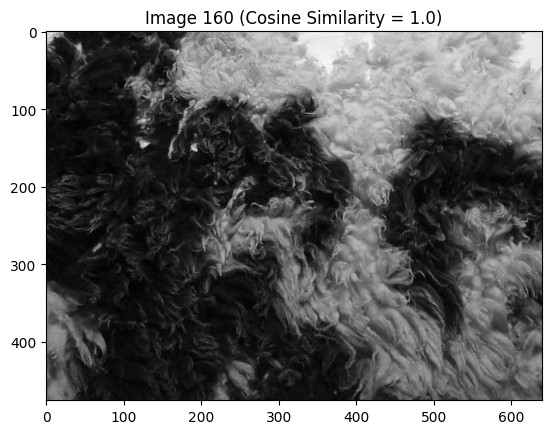

Image 249: Cosine Similarity = 0.8595


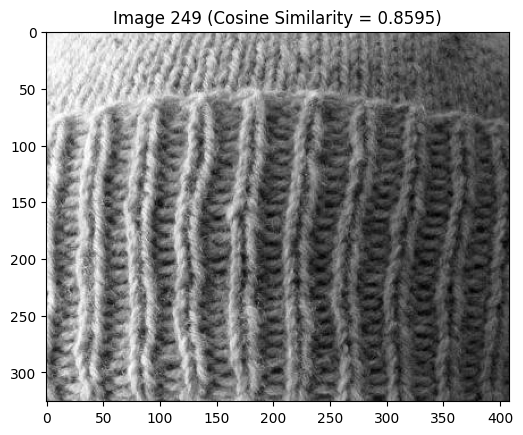

Experiment with 500 images:
Minimum cosine similarity: 0.0
Maximum cosine similarity: 1.0
Image 324: Cosine Similarity = 1.0


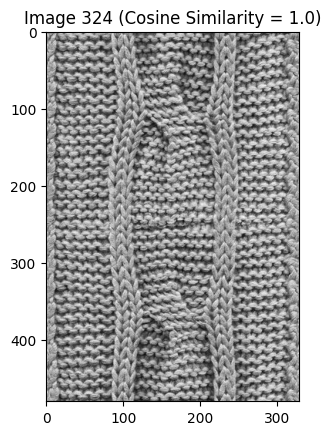

Image 248: Cosine Similarity = 0.8552


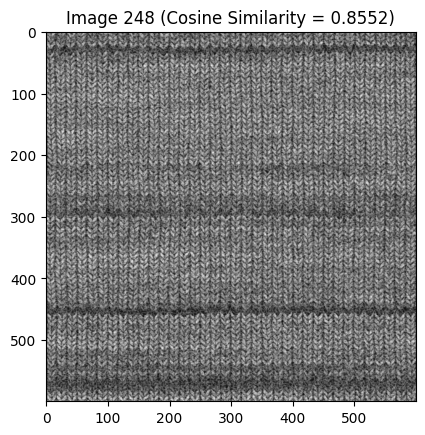

In [ ]:
# Experiment 1: Varying the number of images used to compute centroids
image_results = experiment_vary_images([250, 500])

Experiment with 150 centroids:
Minimum cosine similarity: 0.0
Maximum cosine similarity: 1.0
Image 324: Cosine Similarity = 1.0


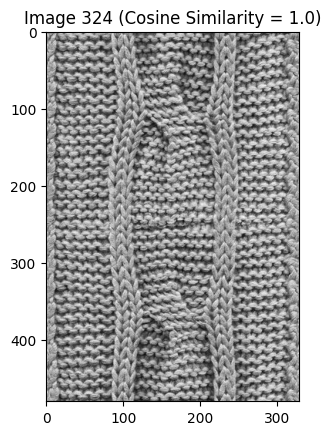

Image 248: Cosine Similarity = 0.8792


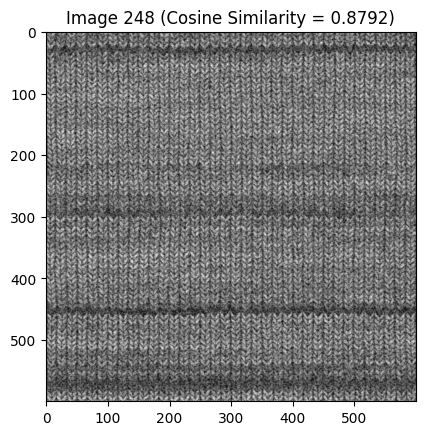

Experiment with 250 centroids:
Minimum cosine similarity: 0.0
Maximum cosine similarity: 1.0
Image 46: Cosine Similarity = 1.0


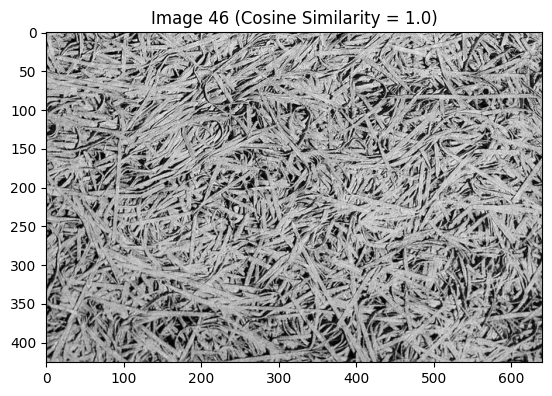

Image 317: Cosine Similarity = 0.8522


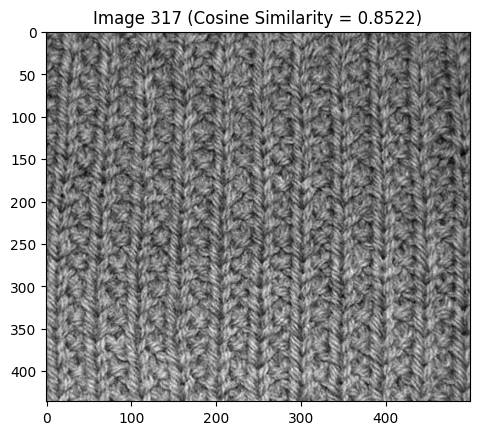

In [ ]:
# Experiment 2: Varying the number of centroids
centroid_results = experiment_vary_centroids([150, 250])

TF-IDF vs BoW Experiment:
TF-IDF Minimum cosine similarity: 0.0
TF-IDF Maximum cosine similarity: 1.0
BoW Minimum cosine similarity: 0.0
BoW Maximum cosine similarity: 0.9778596680543568
Top-k images using TF-IDF:
Image 324: Cosine Similarity = 1.0


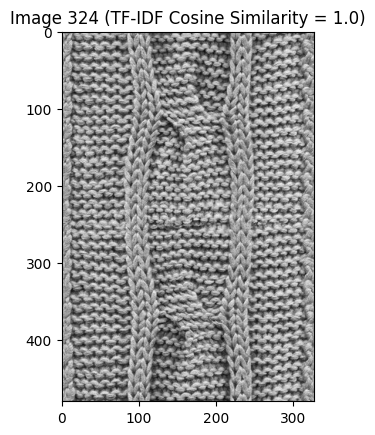

Image 248: Cosine Similarity = 0.8552


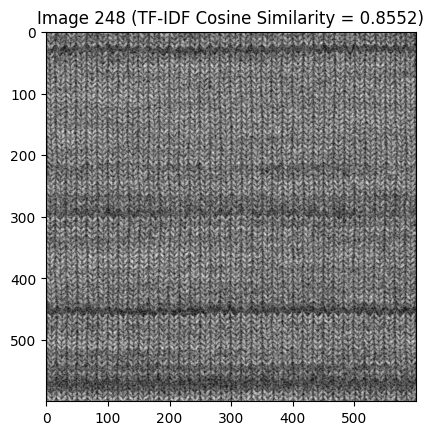

Top-k images using BoW:
Image 324: Cosine Similarity = 0.9779


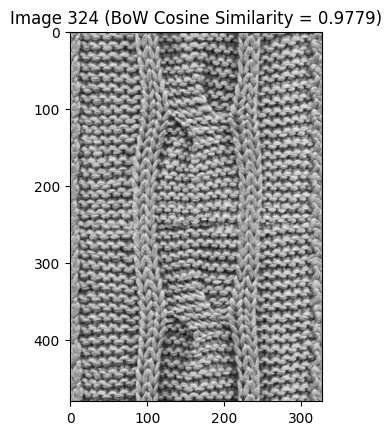

Image 211: Cosine Similarity = 0.8522


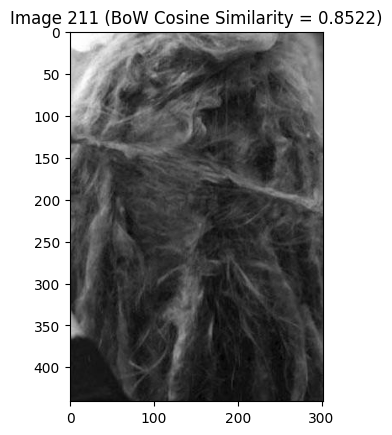

In [ ]:
# Experiment 3: Comparing TF-IDF and Bag of Words (BoW)
tfidf_bow_results = experiment_tfidf_vs_bow()

# **Final Selection of Best Parameters**

In [ ]:
# Identify the best parameters based on maximum cosine similarity
best_num_images = max(image_results, key=lambda x: image_results[x]["max_cosine"])
best_num_centroids = max(centroid_results, key=lambda x: centroid_results[x]["max_cosine"])
best_feature_rep = "TF-IDF" if tfidf_bow_results["tfidf_max_cosine"] > tfidf_bow_results["bow_max_cosine"] else "BoW"

print("\nFinal Selection of Best Parameters:")
print(f"Best number of images for centroids: {best_num_images}")
print(f"Best number of centroids: {best_num_centroids}")
print(f"Best feature representation: {best_feature_rep}")


Final Selection of Best Parameters:
Best number of images for centroids: 250
Best number of centroids: 150
Best feature representation: TF-IDF
